In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import ShuffleSplit 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss 
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE
from keras.models import Sequential 
from keras.layers import Activation 
from keras.layers.core import Dense 
from keras.optimizers import Adam 
from keras.metrics import categorical_crossentropy
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('./creditcard.csv')
print(data.shape)
data.head(5)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 数据预处理

In [4]:
# 检查一下数据是否有缺失值
data.isnull().sum().max()

0

<AxesSubplot:xlabel='Class', ylabel='count'>

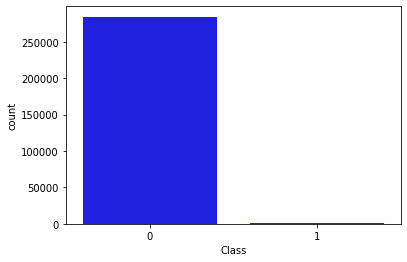

In [5]:
# 查看一下样本各类别的数量,可以看到数据中正负样本分布非常不平衡
# 这里需要注意，如果我们直接使用这种不平衡数据构建模型，那么模型将极度缺乏对那些少量样本的预测能力
# 所以，我们之后会使用上采样/下采样技术对样本进行平衡
sns.countplot(x=data['Class'], color='b')

# 数据可视化

通过构建图表的形式对数据整体的分布进行一个全面的观察

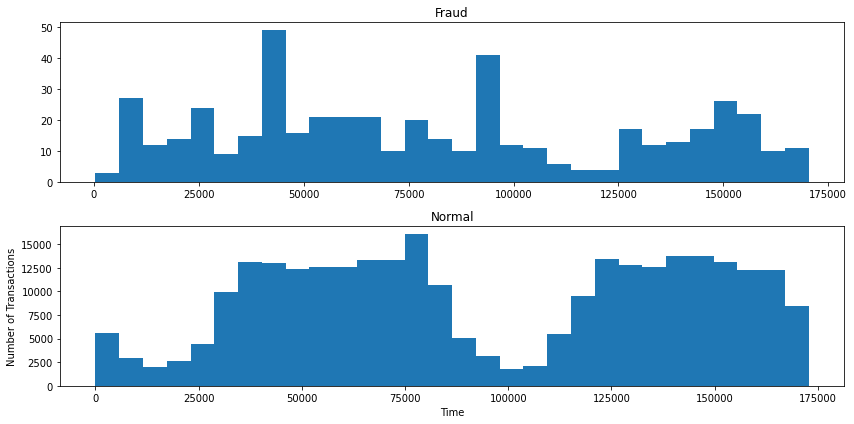

In [6]:
# 首先是欺诈类与正常类的时间维度的对比，可以看出正常交易的时间分布具有一定的规律变化，而欺诈类的交易则无明显的时间规律
plt.figure(figsize=(12, 6))
bins=30

plt.subplot(2, 1, 1)
plt.hist(data.Time[data.Class == 1], bins=bins)
plt.title("Fraud")

plt.subplot(2, 1, 2)
plt.hist(data.Time[data.Class == 0], bins=bins)
plt.title("Normal")

plt.xlabel('Time')
plt.ylabel('Number of Transactions')

plt.tight_layout()

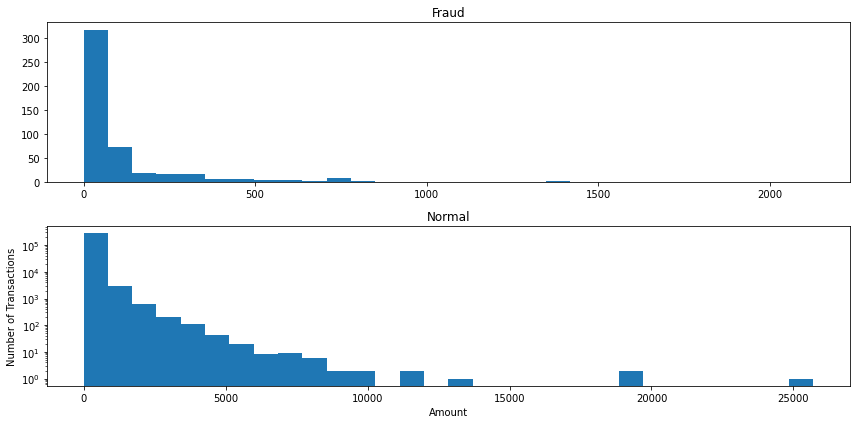

In [7]:
# 接着是订单金额之间的对比，这里两类交易均以长尾分布形式存在，但在金额上欺诈类的订单大多是小型订单，金额一般不超过1000，而正产交易则在0-15000之间不等
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.hist(data.Amount[data.Class == 1], bins=bins)
plt.title('Fraud')

plt.subplot(2, 1, 2)
plt.hist(data.Amount[data.Class == 0], bins=bins)
plt.title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.tight_layout()


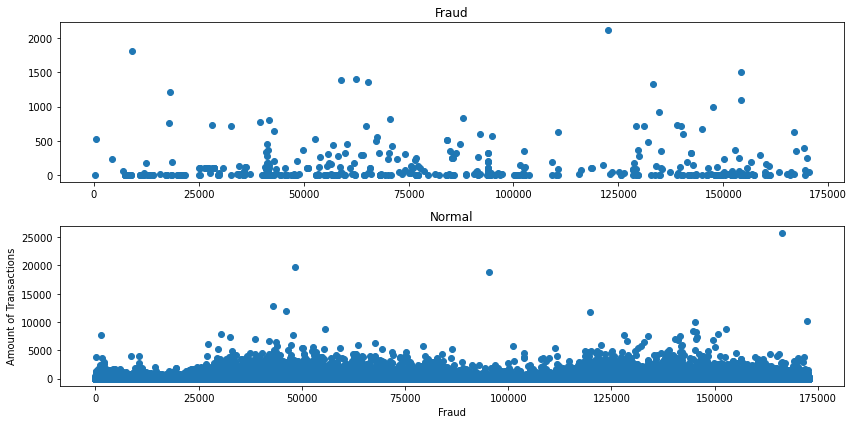

In [8]:
# 绘制时间与金额的散点图，可以看出正常交易均匀分布于各个时间点，而且交易金额的异常值较少出现
# 而欺诈交易的时间分布散乱，并且异常值出现的频率较大
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.scatter(data.Time[data.Class == 1], data.Amount[data.Class == 1])
plt.title('Fraud')

plt.subplot(2, 1, 2)
plt.scatter(data.Time[data.Class == 0], data.Amount[data.Class == 0])
plt.title('Normal')

plt.xlabel('Fraud')
plt.ylabel('Amount of Transactions')

plt.tight_layout()

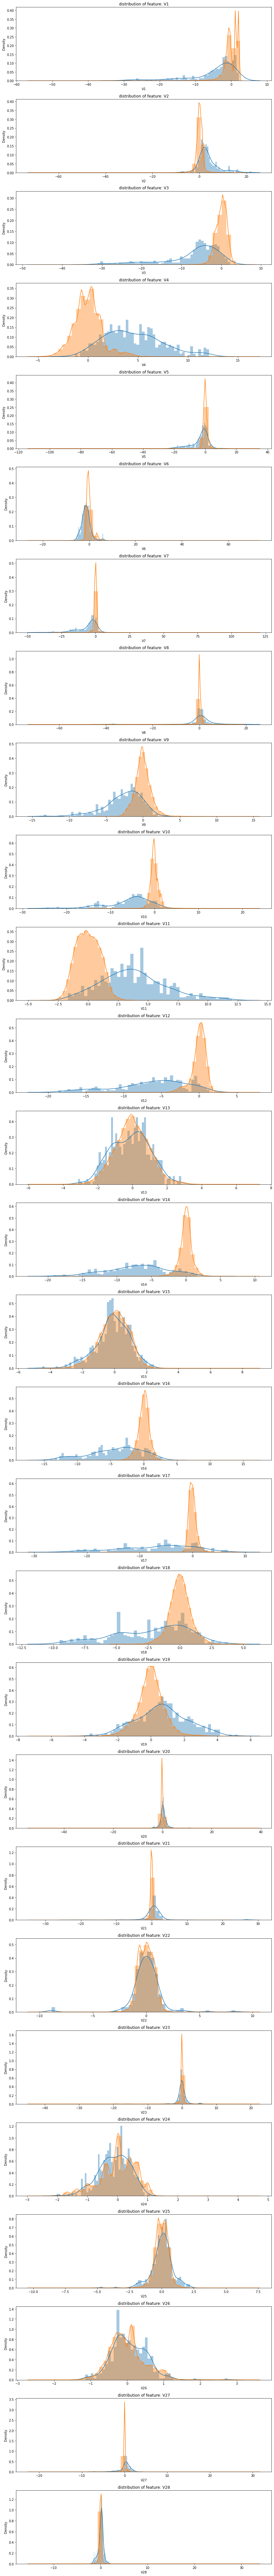

In [9]:
# 接下来，将会把其余经过PCA处理的各个特征分布全部输出出来，并观察每一个特征所属正常和欺诈类中的分布情况
v_features = data.iloc[:, 1:29].columns
plt.figure(figsize=(12, 28*4))
for i, c in enumerate(data[v_features]):
    ax = plt.subplot(28, 1, i+1)
    sns.distplot(data[data.Class==1][c], bins=50)
    sns.distplot(data[data.Class==0][c], bins=50)
    ax.set_title(f'distribution of feature: {c}')
    
plt.tight_layout()

In [10]:
# 通过观察我们发现，其中V6,V8,V13,V20,V22,V23,V24,V25,V26在两种类别中的分布非常相似，而相似的分布形状，则意味着该特征对于最后的预测结果的影响不大，故将其删去
data.drop(['V6', 'V8', 'V13', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26'], axis=1, inplace=True)
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V21', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# 数据标准化

In [11]:
# 对于数据集中的TIime和Amount特征，需要将其区间进行缩放，因为这两个特征的区间大小要远大于其他特征
# 这在某些模型中会因为数值较大的关系将其判定为较重要的特征，所以需要将其标准化
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time_scaled'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data.drop(['Amount', 'Time'], axis=1, inplace=True)
data.head(5)

,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,...,V16,V17,V18,V19,V21,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.239599,0.363787,0.090794,-0.551600,-0.617801,...,-0.470401,0.207971,0.025791,0.403993,-0.018307,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.078803,-0.255425,-0.166974,1.612727,1.065235,...,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,0.791461,-1.514654,0.207643,0.624501,0.066084,...,-2.890083,1.109969,-0.121359,-2.261857,0.247998,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,0.237609,-1.387024,-0.054952,-0.226487,0.178228,...,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.592941,0.817739,0.753074,-0.822843,0.538196,...,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0.219422,0.215153,0,-0.073403,-1.996541


# 分割/预留原始训练集

In [12]:
# 由于之后需要对数据进行采样，这会改变原始的数据集，所以需要先预留一份数据
# 还有这里的StratifiedShuffleSplit方法需要解释一下
# 它就是StratifiedKFold和ShuffleSplit的组合形式，它可以保证每一折的每个类别样本的比例相同，同时将样本随机打乱，根据参数划分出train/test对
# 我们需要用它保持测试集的不平衡性
x = data.drop('Class', axis=1)
y = data['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)

for train_index, test_index in sss.split(x, y):
    normal_xtrain, normal_xtest = x.iloc[train_index], x.iloc[test_index]
    normal_ytrain, normal_ytest = y.iloc[train_index], y.iloc[test_index]

In [13]:
normal_xtrain = normal_xtrain.values
normal_xtest = normal_xtest.values
normal_ytrain = normal_ytrain.values
normal_ytest = normal_ytest.values

# 下采样（UnderSampling）

In [14]:
# 下采样的操作其实非常简单，只需要随机从多量样本中抽取与少量样本相同数量的样本量就可以了。这里生成了一个新的数据集，叫做data_new
data = data.sample(frac=1)

data_0 = data[data.Class == 0][:492]
data_1 = data[data.Class == 1]
print(len(data_0), len(data_1))
data_new = pd.concat([data_0, data_1])

data_new = data_new.sample(frac=1)
data_new.head(5)

492 492


,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,...,V16,V17,V18,V19,V21,V27,V28,Class,Amount_scaled,Time_scaled
209498,-1.720177,-1.678122,0.971030,5.012786,3.375895,-1.422995,-2.082137,2.037952,0.528942,0.435690,...,0.385336,-0.457409,0.405376,1.566328,0.048121,0.213181,0.361589,0,-0.197304,0.900735
68076,-1.108501,0.464714,0.243539,1.106156,-0.337127,0.898030,-0.533811,-0.337592,-0.350418,-0.174399,...,-0.445970,0.182996,0.499586,1.396172,0.110696,0.204875,0.133958,0,0.670241,-0.884325
252196,-0.426590,-0.784008,0.900719,-3.002282,-0.056839,-0.266624,-2.308107,0.772503,0.050349,-0.653885,...,-0.149824,-0.131381,0.591468,-0.328264,-0.042226,0.104198,0.128779,0,-0.293258,1.281946
79525,-2.630598,5.125759,-6.092255,5.527393,1.605145,-3.207076,-5.074871,-6.778331,5.725255,-6.949172,...,-1.707501,-1.685473,0.274891,-2.028885,-0.527474,0.782036,0.628528,1,-0.349231,-0.773960
256067,-1.013497,1.815579,-1.161646,-0.626561,0.112451,0.267910,-0.298117,0.040499,0.269754,1.174915,...,0.037296,-0.580878,0.750646,0.400343,0.427313,0.469825,0.305375,0,-0.346073,1.320566


<AxesSubplot:xlabel='Class', ylabel='count'>

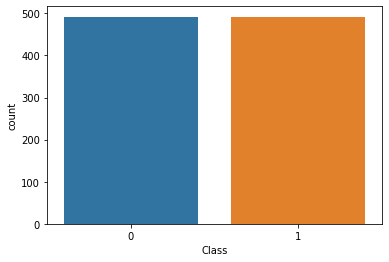

In [15]:
sns.countplot(x=data_new.Class)

In [16]:
x_new = data_new.drop('Class', axis=1)
y_new = data_new.Class

x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=.2, random_state=42)

# 构建/选择模型
一共四个预选模型，观察它们预测表现情况，选择性能最好的模型。

这四个模型分别是：逻辑回归（LogisticRegression），KNN，向量机（SVM）和决策树（Decision Tree）

In [17]:
classfiers = {
    'LogisticRegression': LogisticRegression(), 
    'KNearest': KNeighborsClassifier(), 
    'SupportVectorClassifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [18]:
for keys, classifier in classfiers.items():
    classifier.fit(x_train, y_train)
    train_score = cross_val_score(classifier, x_train, y_train, cv=5)
    print(f'{classifier.__class__.__name__} accuracy score: {100*train_score.mean():.2f}%')

LogisticRegression accuracy score: 94.15%
KNeighborsClassifier accuracy score: 94.54%
SVC accuracy score: 93.27%
DecisionTreeClassifier accuracy score: 90.59%


In [20]:
# 接下来使用网格搜索，对各个模型进行调参，并且保留每个模型性能最好的参数
log_reg_params = {"penalty": ['l1', 'l2'], "C": [.001, .01, .1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(x_train, y_train)
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2, 5, 1)), "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(x_train, y_train)
knears_neighbors = grid_knears.best_estimator_

svc_params = {"C": [.5, .7, .9, 2], "kernel": ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(x_train, y_train)
svc = grid_svc.best_estimator_

tree_params = {"criterion": ['gini', 'entropy'], 'max_depth': list(range(2, 4, 1)), 'min_samples_leaf': list(range(5, 7, 1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(x_train, y_train)
tree_clf = grid_tree.best_estimator_


In [21]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

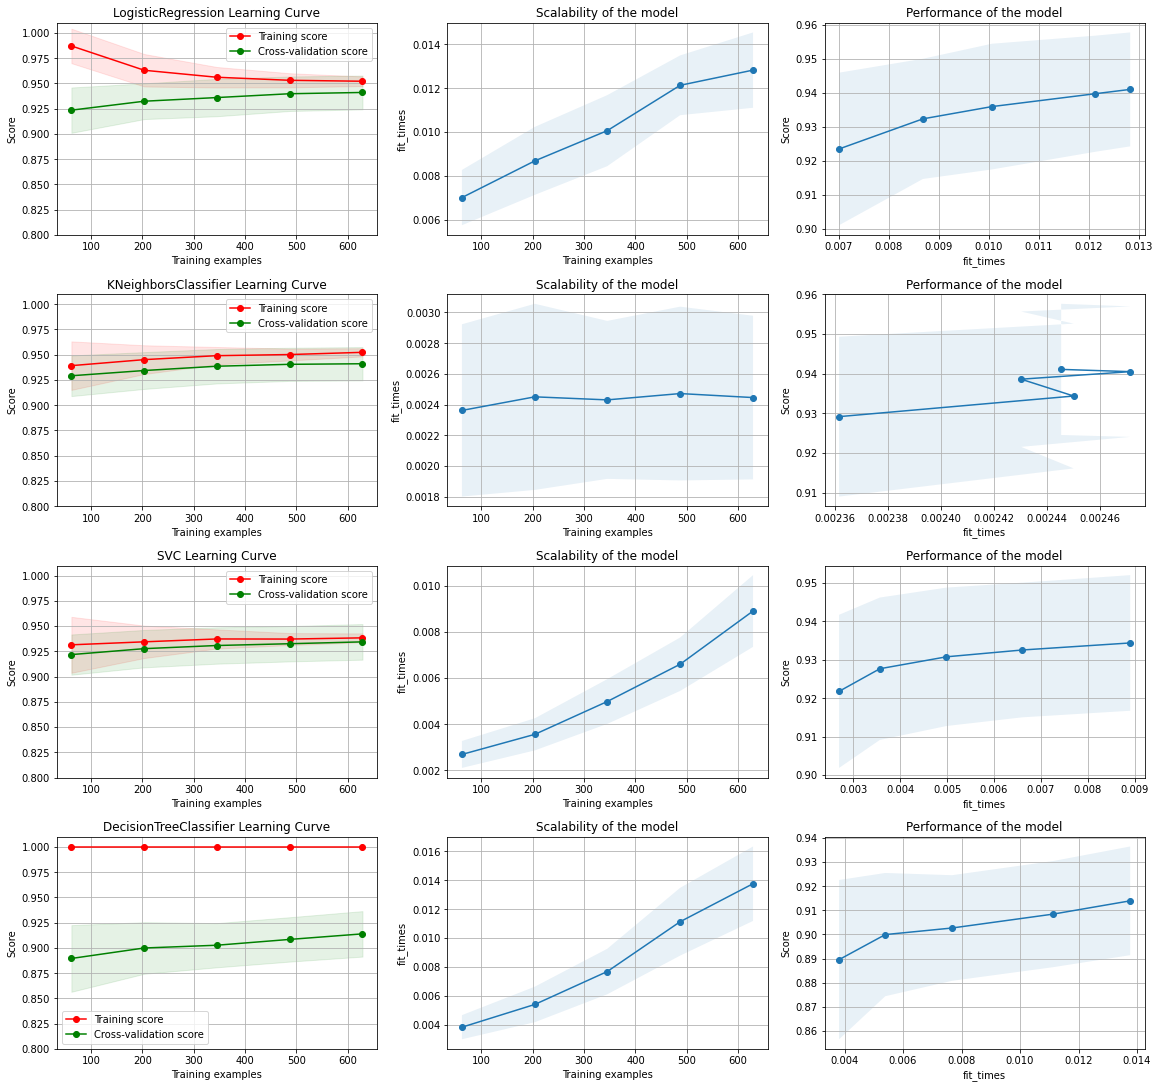

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(16,15), constrained_layout=True)


for i, (key, classifier) in enumerate(classfiers.items()):
    title = f'{classifier.__class__.__name__} Learning Curve'
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    plot_learning_curve(classifier, title, x_train, y_train, axes=axes[i, :], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [23]:
train_scores = {key:[] for key in classfiers.keys()}
for i in range(len(x_train)):
    tmp_x_train = x_train.iloc[:i+1]
    tmp_y_train = y_train.iloc[:i+1]
    for keys, classifier in classfiers.items():
        classifier.fit(tmp_x_train, tmp_y_train)
        train_score = cross_val_score(classifier, tmp_x_train, tmp_y_train, cv=5)
        train_scroe[key].append(train_score)
        print(f'{classifier.__class__.__name__} accuracy score: {100*train_score.mean():.2f}%')

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [24]:
# 对模型进行评估，这里使用交叉验证
log_reg_score = cross_val_score(log_reg, x_train, y_train, cv=5)
print(f"Logistic Regression Cross Validation Score: {100*log_reg_score.mean():.2f}%")

knears_score = cross_val_score(knears_neighbors, x_train, y_train, cv=5)
print(f"Knears Neighbors Cross Validation Score: {100*knears_score.mean():.2f}%")

svc_score = cross_val_score(svc, x_train, y_train, cv=5)
print(f"Support Vector Machine Cross Validation Score: {100*svc_score.mean():.2f}%")

tree_score = cross_val_score(tree_clf, x_train, y_train, cv=5)
print(f"DecisionTree Classifier Cross Validation Score: {100*tree_score.mean():.2f}%")


Logistic Regression Cross Validation Score: 94.66%
Knears Neighbors Cross Validation Score: 94.66%
Support Vector Machine Cross Validation Score: 94.41%
DecisionTree Classifier Cross Validation Score: 93.77%


In [25]:
print(tree_score)

[0.94936709 0.94936709 0.9044586  0.96178344 0.92356688]


In [26]:
# 预测
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

for train, test in sss.split(normal_xtrain, normal_ytrain):
    undersample_pipeline = make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(normal_xtrain[train], normal_ytrain[train])
    undersample_prediction = undersample_model.predict(normal_xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(normal_xtrain[test], normal_ytrain[test]))
    undersample_recall.append(recall_score(normal_ytrain[test], undersample_prediction))
    undersample_precision.append(precision_score(normal_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(normal_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(normal_ytrain[test], undersample_prediction))
    
print(f"accuracy_score: {np.mean(undersample_accuracy)}")
print(f"recall_score: {np.mean(undersample_recall)}")
print(f"precision_score: {np.mean(undersample_precision)}")
print(f"f1_score: {np.mean(undersample_f1)}")
print(f"roc_auc_score: {np.mean(undersample_auc)}")


accuracy_score: 0.4729399372380346
recall_score: 0.9341772151898734
precision_score: 0.003204521378274469
f1_score: 0.006385783153828585
roc_auc_score: 0.7031580734115996


# 上采样（OverSampling）
使用SMOTE算法来进行上采样，作为上采样技术，SMOTE算法并不只是单纯的复制原有的少量样本，
而是为其每个特征选择一个很小幅度波动的区间，进行新的特征生成，并组合这些特征生成该类别的新的样本

In [24]:
#由于原来的逻辑回归是根据下采样的数据集构建的，所选择的参数可能并不适合上采样的数据，所以这里需要重新为其寻找最优参数
# 这里使用RandomizedSearchCV进行调参，相比较GridSearchCV, RandonizedSearchCV并不会尝试全部所设置的参数，所以它会消耗更少的内存和时间
smote_accuracy = []
smote_precision = []
smote_recall = []
smote_f1 = []
smote_auc = []

lr_params = {"penalty": ['l1', 'l2'], "C": [.001, .01, .1, .1, 1, 10, 100, 1000]}
random_lr = RandomizedSearchCV(LogisticRegression(), lr_params)

for train, test in sss.split(normal_xtrain, normal_ytrain):
    smote_pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), random_lr)
    model = smote_pipeline.fit(normal_xtrain[train], normal_ytrain[train])
    best_est = random_lr.best_estimator_
    smote_prediction = best_est.predict(normal_xtrain[test])
    
    smote_accuracy.append(smote_pipeline.score(normal_xtrain[test], normal_ytrain[test]))
    smote_recall.append(recall_score(normal_ytrain[test], smote_prediction))
    smote_precision.append(precision_score(normal_ytrain[test], smote_prediction))
    smote_f1.append(f1_score(normal_ytrain[test], smote_prediction))
    smote_auc.append(roc_auc_score(normal_ytrain[test], smote_prediction))
    
print(f"accuracy_score: {np.mean(smote_accuracy)}")
print(f"recall_score: {np.mean(smote_recall)}")
print(f"precision_score: {np.mean(smote_precision)}")
print(f"f1_score: {np.mean(smote_f1)}")
print(f"roc_auc_score: {np.mean(smote_auc)}")

d:\codeprograms\python37\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\codeprograms\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\codeprograms\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\codeprograms\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
d:\codeprograms\python37\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this trai

accuracy_score: 0.9774715266957801
recall_score: 0.8759493670886076
precision_score: 0.06396006146376683
f1_score: 0.11918313882238558
roc_auc_score: 0.926798600888775


# 测试集/混淆矩阵

In [35]:
import itertools

def plot_confusion_matrix(cm, classes, normalized=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix with out normalization")
    
    print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

In [54]:
labels = ["No Frud", "Fraud"]

Confusion matrix with out normalization
[[26303 30561]
 [    6    92]]


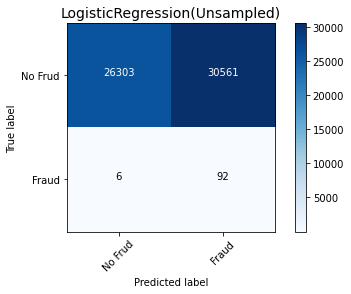

In [36]:
# 下采样
y_pred_undersample = log_reg.predict(normal_xtest)
lr_under_matrix = confusion_matrix(normal_ytest, y_pred_undersample)
plot_confusion_matrix(lr_under_matrix, labels, title="LogisticRegression(Unsampled)")

Confusion matrix with out normalization
[[55469  1395]
 [   11    87]]


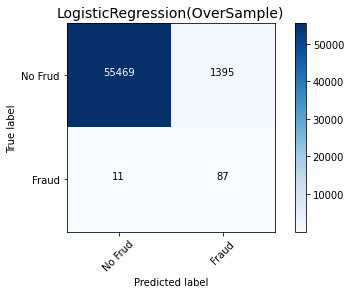

In [37]:
# 上采样
y_pred_sm = best_est.predict(normal_xtest)
lr_over_matrix = confusion_matrix(normal_ytest, y_pred_sm)
plot_confusion_matrix(lr_over_matrix, labels, title="LogisticRegression(OverSample)")

# 神经网络（Neural Network）
这里构建一个拥有两个隐藏层的神经网络，这里使用keras包构建模型。

首先是下采样的NN,
第一层隐藏层有21个神经元，激活函数使用relu，
第二层有32个神经元，激活函数同上，
最后一层，由于是2分类，所以使用sigmoid函数作为激活函数

In [38]:
# undersampling NN
n_inputs = normal_xtrain.shape[1]

under_model = Sequential()
under_model.add(Dense(n_inputs, input_shape=(n_inputs,), activation="relu"))
under_model.add(Dense(32, activation="relu"))
under_model.add(Dense(2, activation="sigmoid"))

under_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21)                462       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 使用分类误差作为损失函数，并用Adam算法作为优化器，评估指标使用准确率。batch_size设置为20，整个数据集共迭代20次
under_model.compile(Adam(lr=.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
under_model.fit(x_train, y_train, validation_split=.2, batch_size=20, epochs=20, shuffle=True)


Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.4156 - accuracy: 0.8410 - val_loss: 0.3525 - val_accuracy: 0.8987
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.9110 - val_loss: 0.2851 - val_accuracy: 0.9367
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.2562 - accuracy: 0.9205 - val_loss: 0.2354 - val_accuracy: 0.9430
Epoch 4/20
32/32 [==============================] - 0s 2ms/step - loss: 0.2181 - accuracy: 0.9221 - val_loss: 0.2003 - val_accuracy: 0.9557
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1949 - accuracy: 0.9332 - val_loss: 0.1742 - val_accuracy: 0.9620
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.9364 - val_loss: 0.1577 - val_accuracy: 0.9620
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9364 - val_loss: 0.1541 - val_accuracy: 0.9620
Epoch 8/20
32/32 [==

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
recall score: 0.9285714285714286
Confusion matrix with out normalization
[[54787  2077]
 [    7    91]]


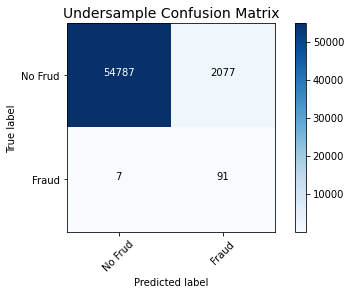

In [41]:
under_prediction = under_model.predict_classes(normal_xtest, batch_size=200)
print(f"recall score: {recall_score(normal_ytest, under_prediction)}")
under_matrix = confusion_matrix(normal_ytest, under_prediction)
plot_confusion_matrix(under_matrix, labels, title="Undersample Confusion Matrix")

In [42]:
# over sampling
smote = SMOTE(sampling_strategy="minority")
x_train_sm, y_train_sm = smote.fit_resample(normal_xtrain, normal_ytrain)

In [44]:
# oversampling NN

over_model = Sequential()
over_model.add(Dense(n_inputs, input_shape=(n_inputs,), activation="relu"))
over_model.add(Dense(32, activation="relu"))
over_model.add(Dense(2, activation="sigmoid"))

over_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 21)                462       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                704       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
_________________________________________________________________


In [48]:
over_model.compile(Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
over_model.fit(x_train_sm, y_train_sm, validation_split=.2, batch_size=200, epochs=20, shuffle=True)

Epoch 1/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.0151 - val_accuracy: 0.9985
Epoch 2/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.0067 - val_accuracy: 0.9998
Epoch 3/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0072 - val_accuracy: 0.9995
Epoch 4/20
1820/1820 [==============================] - 4s 2ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.0082 - val_accuracy: 0.9995
Epoch 5/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0054 - val_accuracy: 0.9998
Epoch 6/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0049 - val_accuracy: 0.9997
Epoch 7/20
1820/1820 [==============================] - 3s 2ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0060 - val_accuracy:

recall score: 0.8367346938775511
Confusion matrix with out normalization
[[56797    67]
 [   16    82]]


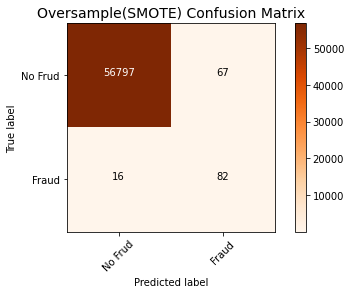

In [53]:
over_prediction = over_model.predict_classes(normal_xtest, batch_size=200)
print(f"recall score: {recall_score(normal_ytest, over_prediction)}")
oversample_matrix = confusion_matrix(normal_ytest, over_prediction)
plot_confusion_matrix(oversample_matrix, labels, title="Oversample(SMOTE) Confusion Matrix", cmap=plt.cm.Oranges)